In [1]:
include("../BayesianUtilities.jl")
using Distributions, LinearAlgebra, Plots, Random, .BayesianUtilities

In [2]:
Random.seed!(0);

In [3]:
# Synthetic data
A = [1 0.1; 0 1]
B = [1 0]
Q = [0.1^3/3 0.1^2/2; 0.1^2/2 0.1]
R = 1

T = 20

x_real = zeros(2,T)
y_real = zeros(T)

x_real[:,1] = rand(MvNormal(zeros(2),diagm(0=>ones(2))))
y_real[1] = rand(Normal((B*x_real[:,1])[1],R))
for t=2:T
    x_real[:,t] = rand(MvNormal(A*x_real[:,t-1],Q))
    y_real[t] = rand(Normal((B*x_real[:,t])[1],R))
end

In [4]:
y_real

20-element Array{Float64,1}:
  0.3261000257351814
  1.0568225415877555
  0.33488552774460556
  0.20351370657896806
  0.7479205504900681
 -1.2455230446004775
  1.27355957191447
  1.470783589024301
  1.3878938365272515
  1.1824394337610564
  2.7681297254308275
  2.9348123236782953
  4.2741749493826
  2.6142077124145726
  1.735733594535381
  3.3246104345825533
  4.669086124510816
  3.1551350999035694
  3.485116336997867
  3.1229126973273384

In [5]:
# Inference with Filtering
p1 = MvNormal(zeros(2),diagm(0=>ones(2)))

forward_estimates = Array{MvNormal}(undef, T)
forward_estimates[1] = collide(p1,B\Normal(y_real[1],R))

for t=2:T
    predict = A*forward_estimates[t-1] + MvNormal(zeros(2),Q)
    forward_estimates[t] = collide(predict,B\Normal(y_real[t],R))
end

In [6]:
forward_estimates

20-element Array{MvNormal,1}:
 FullNormal(
dim: 2
μ: [0.1630500128675907, 0.0]
Σ: [0.5 0.0; 0.0 1.0]
)

 FullNormal(
dim: 2
μ: [0.46505083861699975, 0.06213602881192935]
Σ: [0.3378945045243876 0.06952107702493932; 0.06952107702493932 1.0927002869123816]
)

 FullNormal(
dim: 2
μ: [0.4349390897235055, 0.043747074024985254]
Σ: [0.2663560720268001 0.13483722872415407; 0.13483722872415407 1.1679184035534642]
)

 FullNormal(
dim: 2
μ: [0.38415691583631134, -0.002611224602260206]
Σ: [0.2339137409223781 0.1966000035016871; 0.1966000035016871 1.2174651276737996]
)

 FullNormal(
dim: 2
μ: [0.46479622646227714, 0.0889360392431602]
Σ: [0.22223882168778 0.25148636749658076; 0.25148636749658076 1.2361478868546172]
)

 FullNormal(
dim: 2
μ: [0.0921454359060764, -0.41951329678565696]
Σ: [0.22192969819597594 0.2957454213066203; 0.2957454213066203 1.2237347102804257]
)

 FullNormal(
dim: 2
μ: [0.32788958883364205, -0.019382461030357682]
Σ: [0.22699306985112286 0.327073836051611; 0.327073836051611 1.1853

In [7]:
# Inference with smoothing

smooth_estimates = Array{MvNormal}(undef, T)
smooth_estimates[T] = forward_estimates[T]

joint_dists = Array{MvNormal}(undef, T-1)

for t=T-1:-1:1
    smooth_estimates[t], joint_dists[t] = transit(forward_estimates[t],smooth_estimates[t+1],A,inv(Q))
end

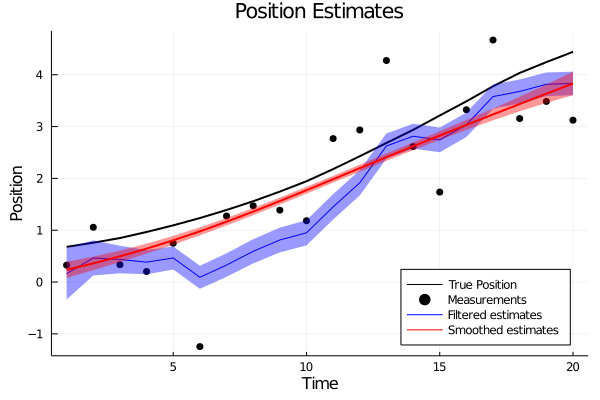

In [8]:
y_filter_m, y_filter_v = zeros(T), zeros(T)
y_smooth_m, y_smooth_v = zeros(T), zeros(T)
for t=1:T
    y_filter_m[t] = mean(forward_estimates[t])[1]
    y_filter_v[t] = cov(forward_estimates[t])[1,1]
    y_smooth_m[t] = mean(smooth_estimates[t])[1]
    y_smooth_v[t] = cov(smooth_estimates[t])[1,1]
end

plot(x_real[1,:], color=:black, lw=2, title="Position Estimates", xaxis="Time", yaxis="Position", label="True Position")
scatter!(collect(1:T), y_real, color=:black, xaxis="Time", yaxis="Position", label="Measurements")
plot!(y_filter_m, color=:blue, ribbon=y_filter_v, fillalpha=0.4, label="Filtered estimates")
plot!(y_smooth_m, lw=2, color=:red, ribbon=y_smooth_v, fillalpha=0.4, label="Smoothed estimates", legend=:bottomright)

In [9]:
smooth_estimates

20-element Array{MvNormal,1}:
 FullNormal(
dim: 2
μ: [0.2361833146023314, 1.1828780592703374]
Σ: [0.1558602389323473 -0.1367565716288408; -0.1367565716288408 0.4081065598795807]
)

 FullNormal(
dim: 2
μ: [0.36036113305847195, 1.3004345321800237]
Σ: [0.13118802827593767 -0.11016193217101948; -0.11016193217101948 0.38678316805402047]
)

 FullNormal(
dim: 2
μ: [0.4963375424052679, 1.4200106460976614]
Σ: [0.11165994376202668 -0.0855752446093733; -0.0855752446093733 0.3614726969586408]
)

 FullNormal(
dim: 2
μ: [0.6445197518772474, 1.5442814479925937]
Σ: [0.09674499429403587 -0.06416307056381443; -0.06416307056381443 0.335198007296848]
)

 FullNormal(
dim: 2
μ: [0.8052499119263706, 1.6702346475650272]
Σ: [0.08574923439710568 -0.04641872297758325; -0.04641872297758325 0.31026086273591613]
)

 FullNormal(
dim: 2
μ: [0.9785397054117144, 1.795378567781287]
Σ: [0.07793275389275106 -0.03233556159130428; -0.03233556159130428 0.28830476244308434]
)

 FullNormal(
dim: 2
μ: [1.1639184174855137, 1.908

In [10]:
joint_dists

19-element Array{MvNormal,1}:
 FullNormal(
dim: 4
μ: [0.36036113305847195, 1.3004345321800237, 0.2361833146023314, 1.1828780592703374]
Σ: [0.13118802827593767 -0.11016193217101948 0.14161551216500826 -0.09885979731760855; -0.11016193217101948 0.38678316805402047 -0.14699083118104836 0.3502847815838273; 0.14161551216500826 -0.14699083118104836 0.1558602389323473 -0.1367565716288408; -0.09885979731760855 0.3502847815838273 -0.1367565716288408 0.4081065598795807]
)

 FullNormal(
dim: 4
μ: [0.4963375424052679, 1.4200106460976614, 0.36036113305847195, 1.3004345321800237]
Σ: [0.11165994376202668 -0.0855752446093733 0.11963351738464834 -0.07451784336076177; -0.0855752446093733 0.3614726969586408 -0.11995231740911026 0.32677218080868964; 0.11963351738464834 -0.11995231740911026 0.13118802827593767 -0.11016193217101948; -0.07451784336076177 0.32677218080868964 -0.11016193217101948 0.38678316805402047]
)

 FullNormal(
dim: 4
μ: [0.6445197518772474, 1.5442814479925937, 0.4963375424052679, 1.42001